<a href="https://colab.research.google.com/github/praffulp/energy-demand-prediction/blob/main/Energy_Demand_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset covers 2106 days between 1 January 2015 and 6 October 2020. During some intraday intervals RRP was negative, so that energy producers were paying consumers rather than wise versa. Below is a brief description fo the data:

date : datetime, the date of the recording <br>
demand : float, a total daily electricity demand in MWh <br>
RRP : float, a recommended retail price in AUD$ / MWh <br>

demand_pos_RRP : float, a total daily demand at positive RRP in MWh<br>
RRP_positive : float, an averaged positive RRP, weighted by the corresponding intraday demand in AUD$ / MWh <br>

demand_neg_RRP : float, an total daily demand at negative RRP in MWh <br>
RRP_negative : float, an average negative RRP, weighted by the corresponding intraday demand in AUD$ / MWh <br>
frac_at_neg_RRP : float, a fraction of the day when the demand was traded at negative RRP <br>
min_temperature : float, minimum temperature during the day in Celsius <br>
max_temperature : float, maximum temperature during the day in Celsius<br>
solar_exposure : float, total daily sunlight energy in MJ/m^2<br>
rainfall : float, daily rainfall in mm<br>
school_day : boolean, if students were at school on that day<br>
holiday : boolean, if the day was a state or national holiday<br>

---



In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy.stats import skewtest, skew, kurtosis, shapiro

pd.pandas.set_option('display.max_columns',None)
df = pd.read_csv("complete_dataset.csv", index_col=[0], parse_dates=[0])

In [3]:
features_with_na = [features for features in df.columns if df[features].isnull().sum()>1]
for feature in features_with_na:
  print(feature, np.round(df[feature].isnull().mean(), 4), "% missing values")

rainfall 0.0014 % missing values


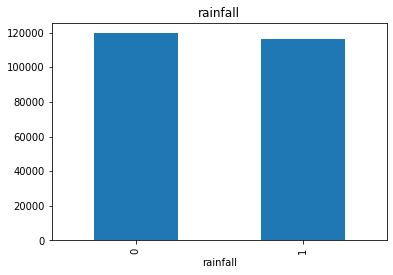

In [4]:
for feature in features_with_na:
    data = df.copy()
    
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    
    # let's calculate the mean demand where the information is missing or present
    data.groupby(feature)['demand'].median().plot.bar()
    plt.title(feature)
    plt.show()

In [5]:
df_null = df.isnull().unstack()
feature_null_index = df_null[df_null]
print(feature_null_index)

                date      
solar_exposure  2017-11-26    True
rainfall        2015-06-11    True
                2018-10-09    True
                2018-10-10    True
dtype: bool


In [6]:
mean_exposure = round(df["solar_exposure"].median(), 1)
mean_rainfall = round(df["rainfall"].median(), 1)
df["solar_exposure"].fillna(mean_exposure, inplace=True)
df["rainfall"].fillna(mean_rainfall, inplace=True)

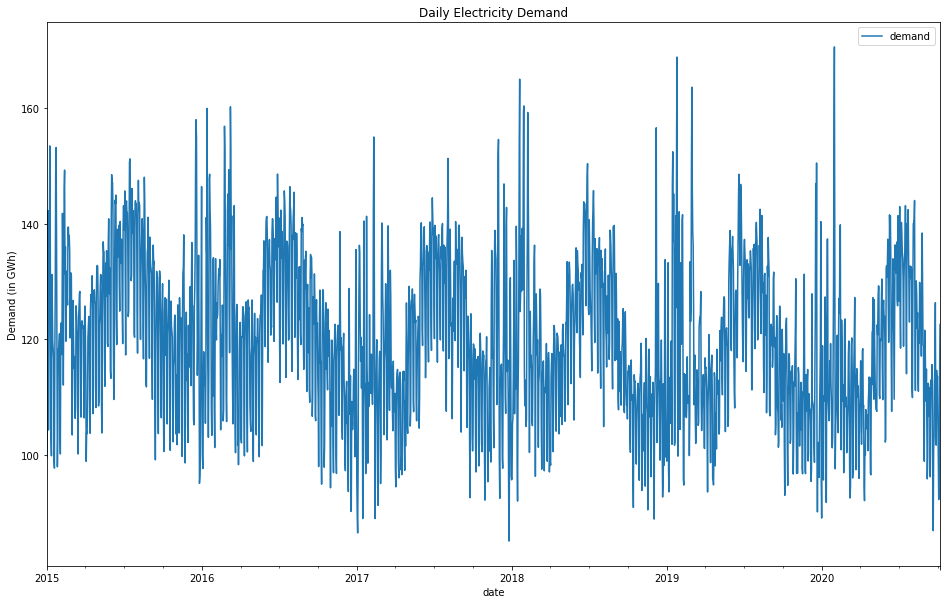

In [7]:
data = df.copy()
date_vs_demand = data[["demand"]]/1000
date_vs_demand.plot(title="Daily Electricity Demand", figsize=(16, 10))
plt.ylabel("Demand (in GWh)")
plt.show()

In [8]:
mean = np.mean(data.demand.values)
std = np.std(data.demand.values)
skewn = skew(data.demand.values)
ex_kurt = kurtosis(data.demand)
print("Skewness: {} \nKurtosis: {}".format(skewn, ex_kurt))

Skewness: 0.18678446719144481 
Kurtosis: -0.33655449147656613


In [9]:
def shapiro_test(data, alpha = 0.05):
    stat, pval = shapiro(data)
    print("H0: Data was drawn from a Normal Ditribution")
    if (pval<alpha):
        print("pval {} is lower than significance level: {}, therefore null hypothesis is rejected".format(pval, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pval, alpha))
        
shapiro_test(data.demand, alpha = 0.05)

H0: Data was drawn from a Normal Ditribution
pval 4.351474203190264e-08 is lower than significance level: 0.05, therefore null hypothesis is rejected


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


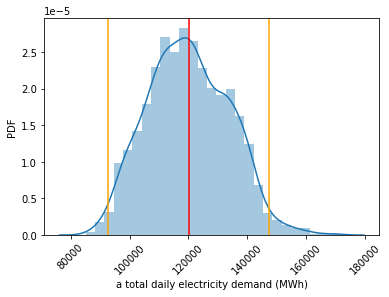

In [10]:
sns.distplot(data.demand)
plt.xticks(rotation = 45)
plt.xlabel("a total daily electricity demand (MWh)")
plt.ylabel("PDF")
plt.axvline(x = mean, color = 'r', linestyle='-', label = "\mu: {0:.2f}%".format(mean))
plt.axvline(x = mean + 2 * std, color = 'orange', linestyle = '-')
plt.axvline(x = mean - 2 * std, color = 'orange', linestyle = '-')
plt.show()

Broadly speaking, data does not look like a normal distribution, because it has a small right tail and the chance of observing extreme values is slightly larger, comparing to normally distributed data



In [11]:
numerical_features = [feature for feature in data.columns if data[feature].dtypes != 'O' and "RRP" not in feature]
print(numerical_features)

['demand', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall']


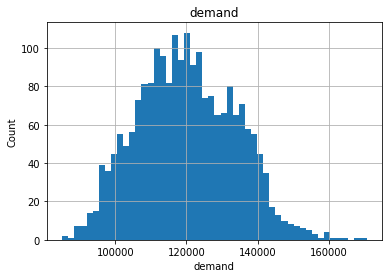

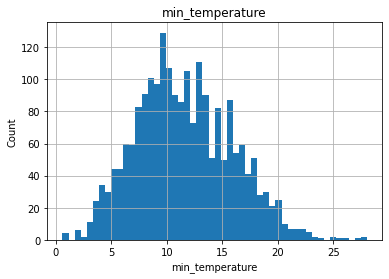

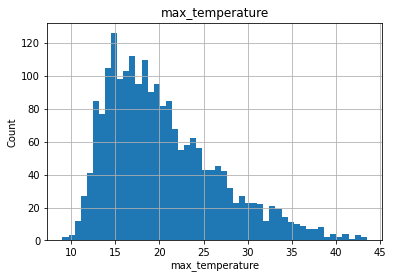

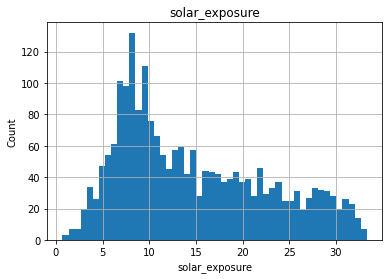

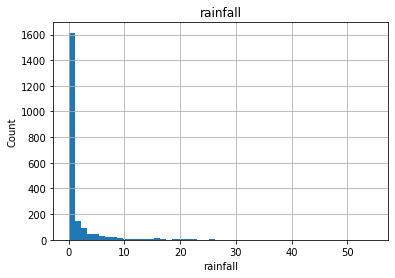

In [12]:
for feature in numerical_features:
    data[feature].hist(bins=50)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

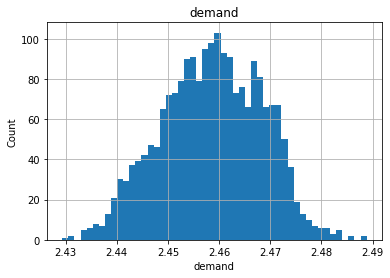

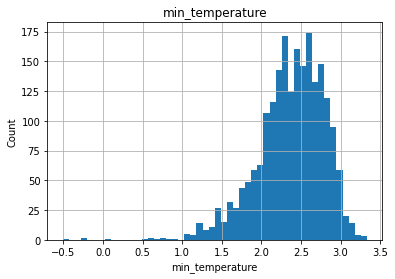

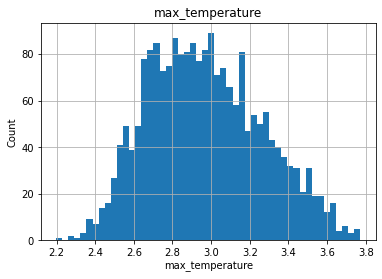

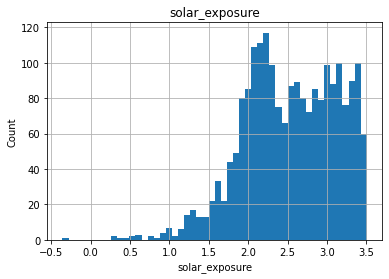

In [13]:
## Trying out logarithmic transformation to normalize distr. of features
for feature in numerical_features:
    dataset = data.copy()
    # dataset["rainfall"].replace({0: 1}, inplace=True)
    if 0 in dataset[feature].unique():
        pass
    else:
        dataset[feature] = np.log(dataset[feature])
        dataset['demand'] = np.log(dataset['demand'])
        dataset[feature].hist(bins=50)
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.title(feature)
        plt.show()
        # plt.scatter(dataset[feature],dataset['demand'])
        # plt.xlabel(feature)
        # plt.ylabel('demand')
        # plt.title("for feature : {}".format(feature))
        # plt.show()

In [14]:
# for feature in numerical_features:
#     dataset = data.copy()
#     if 0 in dataset[feature].unique():
#         pass
#     else:
#         dataset[feature] = np.log(dataset[feature])
#         dataset.boxplot(column=feature)
#         plt.ylabel(feature)
#         plt.title(feature)
#         plt.show()

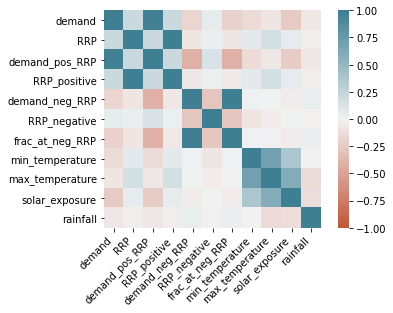

In [15]:
correlation = data.corr()
ax = sns.heatmap(
    correlation, 
    vmin = -1, vmax = 1, center = 0,
    cmap = sns.diverging_palette(20, 220, n=200),
    square = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
);

In [16]:
def create_features(df, label=None):
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['demand_7_days_mean'] = df['demand'].rolling(window = 7).mean()
    df['demand_15_days_mean'] = df['demand'].rolling(window = 15).mean()
    df['demand_30_days_mean'] = df['demand'].rolling(window = 30).mean()
    df['demand_7_days_std'] = df['demand'].rolling(window = 7).std()
    df['demand_15_days_std'] = df['demand'].rolling(window = 15).std()
    df['demand_30_days_std'] = df['demand'].rolling(window = 30).std()
    df['demand_7_days_max'] = df['demand'].rolling(window = 7).max()
    df['demand_15_days_max'] = df['demand'].rolling(window = 15).max()
    df['demand_30_days_max'] = df['demand'].rolling(window = 30).max()
    df['demand_7_days_min'] = df['demand'].rolling(window = 7).min()
    df['demand_15_days_min'] = df['demand'].rolling(window = 15).min()
    df['demand_30_days_min'] = df['demand'].rolling(window = 30).min()
    
    columns = ['dayofweek','quarter','month','year','dayofyear','dayofmonth',
            'weekofyear']
    
    for no_of_days in ('7', '15', '30'):
        for measure_type in ('mean', 'std', 'max', 'min'):
            columns.append(f'demand_{no_of_days}_days_{measure_type}')
    
    X = df[columns]
    if label:
        y = df[label]
        return X, y
    return X

In [17]:
len(pd.date_range(start="2015-01-01", end="2019-01-01"))

1462

In [18]:
split_date = dt.strptime('2019-01-01', '%Y-%m-%d')
train_set = data.loc[data.index <= split_date].copy()
test_set = data.loc[data.index > split_date].copy()

In [19]:
X_train, y_train = create_features(train_set, label = 'demand')
X_test, y_test = create_features(test_set, label = 'demand')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':


In [20]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,demand_7_days_mean,demand_7_days_std,demand_7_days_max,demand_7_days_min,demand_15_days_mean,demand_15_days_std,demand_15_days_max,demand_15_days_min,demand_30_days_mean,demand_30_days_std,demand_30_days_max,demand_30_days_min
date,,,,,,,,,,,,,,,,,,,
2015-01-01,3,1,1,2015,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,4,1,1,2015,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,5,1,1,2015,3,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,6,1,1,2015,4,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,0,1,1,2015,5,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
y_train.head()

date
2015-01-01     99635.030
2015-01-02    129606.010
2015-01-03    142300.540
2015-01-04    104330.715
2015-01-05    118132.200
Name: demand, dtype: float64

In [22]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True)

[11:10:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:109767	validation_1-rmse:106502
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:98892.5	validation_1-rmse:95786.4
[2]	validation_0-rmse:89107.4	validation_1-rmse:86247.4
[3]	validation_0-rmse:80305.7	validation_1-rmse:77668.8
[4]	validation_0-rmse:72386.3	validation_1-rmse:69963.8
[5]	validation_0-rmse:65269.1	validation_1-rmse:62960.4
[6]	validation_0-rmse:58865.2	validation_1-rmse:56752
[7]	validation_0-rmse:53109.6	validation_1-rmse:51229.3
[8]	validation_0-rmse:47937.7	validation_1-rmse:46189.9
[9]	validation_0-rmse:43289.9	validation_1-rmse:41671
[10]	validation_0-rmse:39117.9	validation_1-rmse:37646.8
[11]	validation_0-rmse:35373	validation_1-rmse:34020
[12]	validation_0-rmse:32013.9	validation_1-rmse:3

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

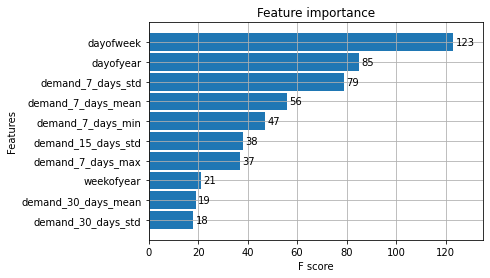

In [24]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

In [25]:
test_set['pred'] = reg.predict(X_test)
d_all = pd.concat([test_set, train_set], sort=False)

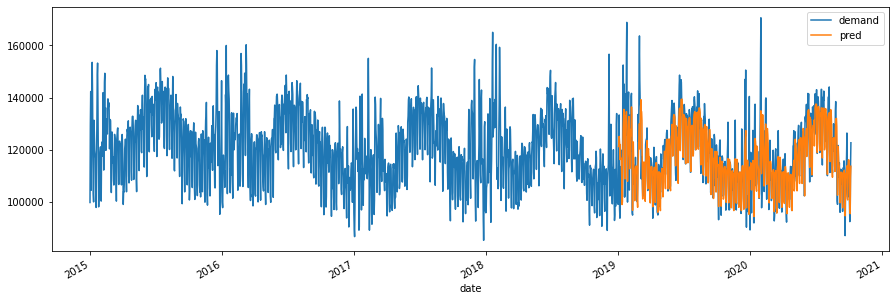

In [26]:
_ = d_all[['demand','pred']].plot(figsize=(15, 5))

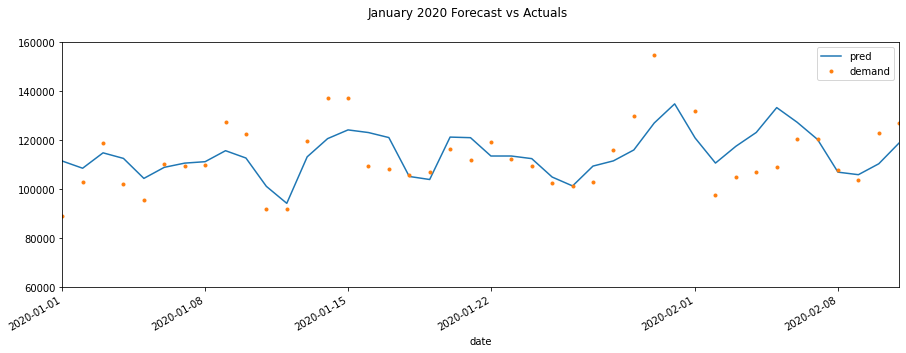

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = d_all[['pred','demand']].plot(ax=ax,  style=['-','.'])
ax.set_xbound(lower='01-01-2020', upper='02-11-2020')
ax.set_ylim(60000, 160000)
plot = plt.suptitle('January 2020 Forecast vs Actuals')

In [28]:
mean_squared_error(y_true=test_set['demand'],
                   y_pred=test_set['pred'])

64046392.28652603

In [30]:
mean_absolute_error(y_true=test_set['demand'],
                   y_pred=test_set['pred'])

5736.093949437112

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
mean_absolute_percentage_error(y_true=test_set['demand'],
                   y_pred=test_set['pred'])

4.858957181551659